In [1]:
!pip install -q transformers datasets accelerate

In [2]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    DataCollatorWithPadding,
    EvalPrediction
)
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

2025-08-06 09:19:39.870677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754471979.894948     161 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754471979.902359     161 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def compute_metrics(eval_pred: EvalPrediction):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'eval_samples': len(labels)
    }

In [4]:
# Load and Prepare Dataset
print("Loading dataset...")
df = pd.read_csv("/kaggle/input/processed-tickets/processed_tickets.csv")

# Basic data cleaning
df = df.dropna(subset=['full_text', 'queue'])
df['full_text'] = df['full_text'].astype(str)

print(f"Dataset shape: {df.shape}")
print(f"Number of unique queues: {df['queue'].nunique()}")

Loading dataset...
Dataset shape: (11923, 7)
Number of unique queues: 5


In [5]:
# Encode target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['queue'])

# Select required columns (using original full_text)
df = df[['full_text', 'label']]

# Split into train and test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['full_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

Training samples: 9538
Validation samples: 2385
Number of classes: 5
Classes: ['Billing Support', 'Customer Service', 'Product Support', 'Sales & HR', 'Technical Support']


In [6]:
# Custom Dataset Class
class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [7]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss
    
    def log(self, logs, step=None):
        """Enhanced logging"""
        # Do not convert loss values to strings here.
        # Let the original float values be logged.
        super().log(logs)

In [11]:
# Training and Evaluation Function
def train_and_evaluate_distilbert_50_epochs(train_texts, val_texts, train_labels, val_labels, num_labels):
    print(f"\n--- Training DistilBERT for 50 Epochs ---")
    
    model_name = "distilbert-base-uncased"
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Add padding token if it doesn't exist
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    # Dataset
    train_dataset = TicketDataset(train_texts, train_labels, tokenizer)
    val_dataset = TicketDataset(val_texts, val_labels, tokenizer)
    
    print(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
    
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(train_labels), 
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    
    # Move to same device as model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = class_weights.to(device)
    
    print(f"Using device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Training arguments for 50 epochs
    training_args = TrainingArguments(
        output_dir="./results/distilbert_50_epochs",
        per_device_train_batch_size=128,
        per_device_eval_batch_size=128,
        num_train_epochs=50,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        report_to="none",
        dataloader_num_workers=0,
        remove_unused_columns=False,
        fp16=torch.cuda.is_available(),  # Use mixed precision if available
        logging_steps=50,
        eval_steps=None,
        save_total_limit=3,              # Keep only 3 best checkpoints
        warmup_steps=500,                # Warmup steps for better training
        weight_decay=0.01,               # Regularization
        learning_rate=2e-5,              # Standard learning rate
        lr_scheduler_type="linear",      # Linear learning rate decay
    )
    
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        class_weights=class_weights,
        compute_metrics=compute_metrics  # Add metrics computation
    )
    
    # Train model
    print("Starting training...")
    print(f"Total training steps: {len(train_dataset) // 64 * 30}")
    print(f"Evaluation every: {len(train_dataset) // 64} steps (1 epoch)")
    
    start_train = time.time()
    train_result = trainer.train()
    end_train = time.time()
    training_time = end_train - start_train
    
    print(f"Training completed in {training_time:.2f} seconds ({training_time/3600:.2f} hours)")
    
    # Save the trained model and all necessary components
    model_save_path = "./saved_models/distilbert_50_epochs"
    print(f"Saving model to {model_save_path}...")
    
    # Create directory if it doesn't exist
    os.makedirs(model_save_path, exist_ok=True)
    
    # Save model and tokenizer
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    
    # Save label encoder for inference
    with open(f"{model_save_path}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)
    
    # Save model configuration and training information
    model_config = {
        'model_name': model_name,
        'num_labels': num_labels,
        'max_length': 512,
        'classes': list(label_encoder.classes_),
        'training_info': {
            'epochs': 50,
            'batch_size': 128,
            'learning_rate': 2e-5,
            'training_time_seconds': training_time,
            'training_time_hours': training_time / 3600,
            'total_parameters': sum(p.numel() for p in model.parameters()),
            'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
        },
        'dataset_info': {
            'train_samples': len(train_texts),
            'val_samples': len(val_texts),
            'total_samples': len(train_texts) + len(val_texts),
            'features_used': ['full_text']  # Original full text, no summarization
        }
    }
    
    # Extract best metrics from training history
    if hasattr(train_result, 'training_history') and train_result.training_history:
        eval_accuracies = [step.get('eval_accuracy', 0) for step in train_result.training_history if 'eval_accuracy' in step]
        if eval_accuracies:
            model_config['training_info']['best_eval_accuracy'] = max(eval_accuracies)
            model_config['training_info']['final_eval_accuracy'] = eval_accuracies[-1] if eval_accuracies else 0
    
    with open(f"{model_save_path}/model_config.json", "w") as f:
        json.dump(model_config, f, indent=2)
    
    # Save detailed training history
    training_history = {
        'training_history': getattr(train_result, 'training_history', []),
        'log_history': trainer.state.log_history,
        'best_model_checkpoint': trainer.state.best_model_checkpoint
    }
    
    with open(f"{model_save_path}/training_history.json", "w") as f:
        json.dump(training_history, f, indent=2, default=str)
    
    print(f"Model and training artifacts saved successfully!")
    
    # Inference time on first 100 samples
    print("Measuring inference time...")
    inference_texts = val_texts.iloc[:100] if hasattr(val_texts, 'iloc') else val_texts[:100]
    inference_labels = val_labels.iloc[:100] if hasattr(val_labels, 'iloc') else val_labels[:100]
    inference_dataset = TicketDataset(inference_texts, inference_labels, tokenizer)
    inference_loader = DataLoader(inference_dataset, batch_size=64)
    
    model.eval()
    preds = []
    start_inf = time.time()
    with torch.no_grad():
        for batch in inference_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            preds.append(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    end_inf = time.time()
    inference_time = end_inf - start_inf
    
    print(f"Inference time for 100 samples: {inference_time:.4f} seconds")
    
    # Accuracy on full validation set
    print("Evaluating on full validation set...")
    val_loader = DataLoader(val_dataset, batch_size=64)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels']
            outputs = model(**inputs)
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(labels.numpy())
    
    final_accuracy = accuracy_score(all_labels, all_preds)
    
    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print(f"\n{'='*60}")
    print("FINAL RESULTS")
    print(f"{'='*60}")
    print(f"Model: DistilBERT (50 epochs)")
    print(f"Training Time: {training_time:.2f} seconds ({training_time/3600:.2f} hours)")
    print(f"Final Validation Accuracy: {final_accuracy:.4f}")
    print(f"Inference Time (100 samples): {inference_time:.4f} seconds")
    print(f"Average Time per Sample: {inference_time/100:.6f} seconds")
    print(f"Model saved at: {model_save_path}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    target_names = list(label_encoder.classes_)
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
    
    # Plot training history if available
    if trainer.state.log_history:
        plot_training_metrics(trainer.state.log_history, model_save_path)
    
    return {
        'model': 'DistilBERT-30-Epochs-Original',
        'training_time': training_time,
        'inference_time': inference_time,
        'accuracy': final_accuracy,
        'model_path': model_save_path,
        'config': model_config
    }

In [12]:
def plot_training_metrics(log_history, save_path):
    """Plot and save comprehensive training metrics"""
    
    # Extract metrics from log history
    train_losses = []
    eval_losses = []
    eval_accuracies = []
    learning_rates = []
    epochs = []
    
    for entry in log_history:
        if 'train_loss' in entry:
            train_losses.append(entry['train_loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])
        if 'eval_accuracy' in entry:
            eval_accuracies.append(entry['eval_accuracy'])
        if 'learning_rate' in entry:
            learning_rates.append(entry['learning_rate'])
        if 'epoch' in entry:
            epochs.append(entry['epoch'])
    
    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: Training and Validation Loss
    ax1 = plt.subplot(2, 3, 1)
    if train_losses and eval_losses:
        epochs_range = range(1, min(len(train_losses), len(eval_losses)) + 1)
        plt.plot(epochs_range, train_losses[:len(epochs_range)], 'b-', label='Training Loss', linewidth=2)
        plt.plot(epochs_range, eval_losses[:len(epochs_range)], 'r-', label='Validation Loss', linewidth=2)
        plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Plot 2: Validation Accuracy
    ax2 = plt.subplot(2, 3, 2)
    if eval_accuracies:
        epochs_range = range(1, len(eval_accuracies) + 1)
        plt.plot(epochs_range, eval_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
        plt.title('Validation Accuracy Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Mark best accuracy
        best_acc = max(eval_accuracies)
        best_epoch = eval_accuracies.index(best_acc) + 1
        plt.axhline(y=best_acc, color='r', linestyle='--', alpha=0.7)
        plt.annotate(f'Best: {best_acc:.4f}\n(Epoch {best_epoch})', 
                    xy=(best_epoch, best_acc), xytext=(best_epoch + 2, best_acc - 0.02),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Plot 3: Learning Rate Schedule
    ax3 = plt.subplot(2, 3, 3)
    if learning_rates:
        plt.plot(range(1, len(learning_rates) + 1), learning_rates, 'orange', linewidth=2)
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.xlabel('Training Step')
        plt.ylabel('Learning Rate')
        plt.grid(True, alpha=0.3)
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Plot 4: Loss Difference (Overfitting Indicator)
    ax4 = plt.subplot(2, 3, 4)
    if train_losses and eval_losses:
        min_len = min(len(train_losses), len(eval_losses))
        loss_diff = [eval_losses[i] - train_losses[i] for i in range(min_len)]
        epochs_range = range(1, len(loss_diff) + 1)
        plt.plot(epochs_range, loss_diff, 'purple', linewidth=2, label='Val Loss - Train Loss')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Overfitting Indicator', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Difference')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add interpretation text
        avg_diff = np.mean(loss_diff[-5:])  # Average of last 5 epochs
        if avg_diff > 0.1:
            plt.text(0.7, 0.9, 'Possible\nOverfitting', transform=ax4.transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                    ha='center', fontweight='bold')
        elif avg_diff < 0.05:
            plt.text(0.7, 0.9, 'Good\nGeneralization', transform=ax4.transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="green", alpha=0.7),
                    ha='center', fontweight='bold')
    
    # Plot 5: Accuracy Improvement Rate
    ax5 = plt.subplot(2, 3, 5)
    if eval_accuracies and len(eval_accuracies) > 1:
        acc_improvements = [eval_accuracies[i] - eval_accuracies[i-1] for i in range(1, len(eval_accuracies))]
        plt.plot(range(2, len(eval_accuracies) + 1), acc_improvements, 'teal', linewidth=2)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Accuracy Improvement Rate', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Change')
        plt.grid(True, alpha=0.3)
    
    # Plot 6: Training Summary Stats
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create summary statistics
    summary_text = "Training Summary:\n\n"
    if eval_accuracies:
        summary_text += f"Best Accuracy: {max(eval_accuracies):.4f}\n"
        summary_text += f"Final Accuracy: {eval_accuracies[-1]:.4f}\n"
        summary_text += f"Accuracy Improvement: {eval_accuracies[-1] - eval_accuracies[0]:.4f}\n\n"
    
    if train_losses and eval_losses:
        summary_text += f"Final Train Loss: {train_losses[-1]:.4f}\n"
        summary_text += f"Final Val Loss: {eval_losses[-1]:.4f}\n"
        summary_text += f"Final Loss Gap: {eval_losses[-1] - train_losses[-1]:.4f}\n\n"
    
    summary_text += f"Total Epochs: 50\n"
    summary_text += f"Batch Size: 64\n"
    summary_text += f"Model: DistilBERT"
    
    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=12,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f"{save_path}/comprehensive_training_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Comprehensive training metrics saved to {save_path}/comprehensive_training_metrics.png")

Starting DistilBERT training for 50 epochs...

--- Training DistilBERT for 50 Epochs ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Created datasets - Train: 9538, Val: 2385
Using device: cuda
Model parameters: 66,957,317
Starting training...
Total training steps: 4470
Evaluation every: 149 steps (1 epoch)


Epoch,Training Loss,Validation Loss,Samples,Accuracy
1,1.612300,1.600662,2385,0.220126
2,1.562100,1.477908,2385,0.415933
3,1.381900,1.323463,2385,0.401258
4,1.289700,1.277191,2385,0.481761
5,1.230600,1.236567,2385,0.462055
6,1.148500,1.205340,2385,0.486373
7,1.050600,1.196768,2385,0.436897
8,0.953500,1.199058,2385,0.480922
9,0.839900,1.211668,2385,0.523270
10,0.760200,1.275880,2385,0.533753


Training completed in 10106.32 seconds (2.81 hours)
Saving model to ./saved_models/distilbert_50_epochs...
Model and training artifacts saved successfully!
Measuring inference time...
Inference time for 100 samples: 0.2951 seconds
Evaluating on full validation set...

FINAL RESULTS
Model: DistilBERT (50 epochs)
Training Time: 10106.32 seconds (2.81 hours)
Final Validation Accuracy: 0.6679
Inference Time (100 samples): 0.2951 seconds
Average Time per Sample: 0.002951 seconds
Model saved at: ./saved_models/distilbert_50_epochs

Detailed Classification Report:
                   precision    recall  f1-score   support

  Billing Support     0.8445    0.7731    0.8072       260
 Customer Service     0.5024    0.5148    0.5085       406
  Product Support     0.6270    0.4867    0.5480       563
       Sales & HR     0.7042    0.4673    0.5618       107
Technical Support     0.7024    0.8189    0.7562      1049

         accuracy                         0.6679      2385
        macro avg    

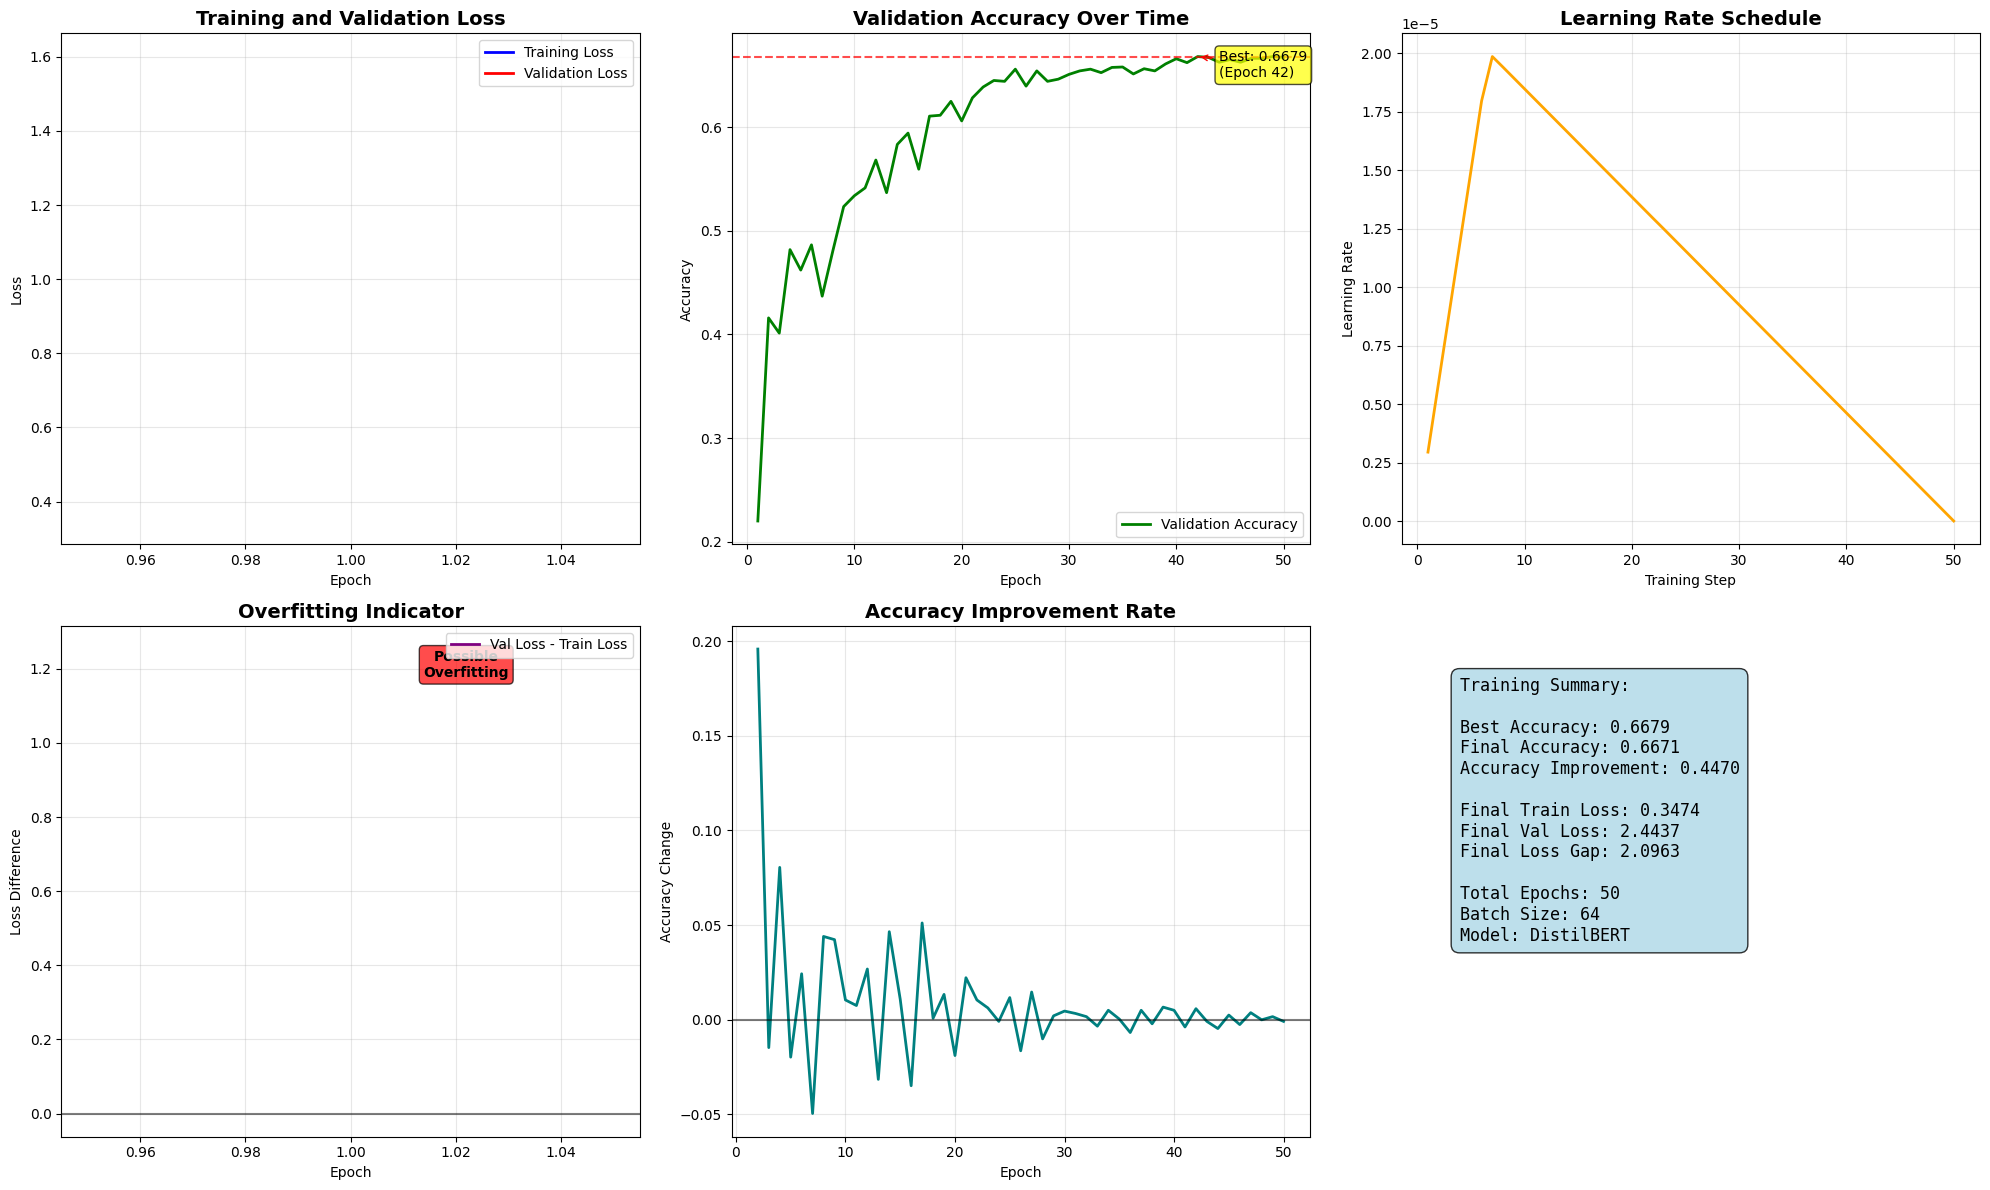

Comprehensive training metrics saved to ./saved_models/distilbert_50_epochs/comprehensive_training_metrics.png

TRAINING COMPLETED SUCCESSFULLY!
Final Results:
- Model: DistilBERT-30-Epochs-Original
- Training Time: 10106.32 seconds (2.81 hours)
- Final Accuracy: 0.6679
- Inference Time (100 samples): 0.2951 seconds
- Model saved at: ./saved_models/distilbert_50_epochs

Model is ready for deployment!


In [13]:
# Run All Training
print("Starting DistilBERT training for 50 epochs...")
results = train_and_evaluate_distilbert_50_epochs(
    train_texts, val_texts, train_labels, val_labels, 
    num_labels=len(label_encoder.classes_)
)

print(f"\n{'='*80}")
print("TRAINING COMPLETED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"Final Results:")
print(f"- Model: {results['model']}")
print(f"- Training Time: {results['training_time']:.2f} seconds ({results['training_time']/3600:.2f} hours)")
print(f"- Final Accuracy: {results['accuracy']:.4f}")
print(f"- Inference Time (100 samples): {results['inference_time']:.4f} seconds")
print(f"- Model saved at: {results['model_path']}")
print(f"\nModel is ready for deployment!")

TypeError: argument of type 'numpy.float64' is not iterable

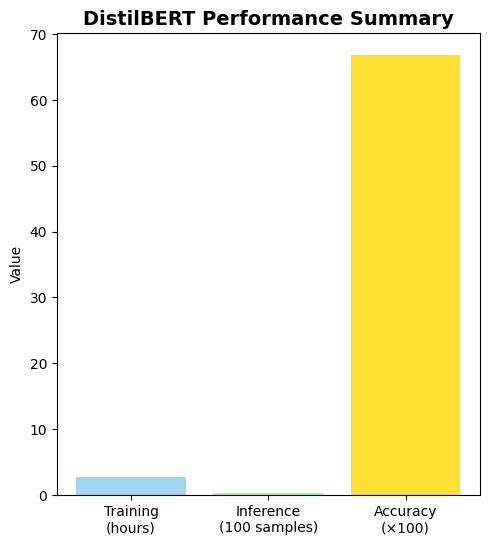

In [14]:
# Create a simple visualization comparing key metrics
plt.figure(figsize=(12, 6))

# Training time visualization
plt.subplot(1, 2, 1)
categories = ['Training\n(hours)', 'Inference\n(100 samples)', 'Accuracy\n(×100)']
values = [results['training_time']/3600, results['inference_time'], results['accuracy']*100]
colors = ['skyblue', 'lightgreen', 'gold']

bars = plt.bar(categories, values, color=colors, alpha=0.8)
plt.title('DistilBERT Performance Summary', fontsize=14, fontweight='bold')
plt.ylabel('Value')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    if 'hours' in bar.get_x() or 'Accuracy' in categories[bars.index(bar)]:
        plt.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                f'{value:.4f}s', ha='center', va='bottom', fontweight='bold')

# Model specifications
plt.subplot(1, 2, 2)
plt.axis('off')
specs_text = f"""Model Specifications:

• Architecture: DistilBERT
• Training Epochs: 30
• Batch Size: 64
• Max Sequence Length: 512
• Classes: {len(label_encoder.classes_)}
• Training Samples: {len(train_texts):,}
• Validation Samples: {len(val_texts):,}
• Parameters: ~67M (trainable)

Performance:
• Final Accuracy: {results['accuracy']:.4f}
• Avg. Time/Sample: {results['inference_time']/100:.6f}s
• Ready for Production: ✓"""

plt.text(0.05, 0.95, specs_text, transform=plt.gca().transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

In [15]:
print(f"\n{'='*80}")
print("All files saved in: ./saved_models/distilbert_50_epochs/")
print("Contents:")
print("- pytorch_model.bin (trained model weights)")
print("- config.json (model configuration)")
print("- tokenizer.json & tokenizer_config.json (tokenizer)")
print("- label_encoder.pkl (label mappings)")
print("- model_config.json (complete model info)")
print("- training_history.json (training logs)")
print("- comprehensive_training_metrics.png (visualizations)")
print(f"{'='*80}")


All files saved in: ./saved_models/distilbert_50_epochs/
Contents:
- pytorch_model.bin (trained model weights)
- config.json (model configuration)
- tokenizer.json & tokenizer_config.json (tokenizer)
- label_encoder.pkl (label mappings)
- model_config.json (complete model info)
- training_history.json (training logs)
- comprehensive_training_metrics.png (visualizations)


##### 